# 图像的匀速运动退化

## 退化滤波器

由于匀速运动类型的退化比较简单，我们可以通过原理性的推导得到其滤波器传递函数。首先，假设快门开关瞬间发生，则曝光时间 $T$ 中对运动画面的成像可以用这样一个简单的积分表达

$$ g(x, y) = \int_0^T f[x - x_0(t), y - y_0(t)] \mathrm{d}t $$

计算上式的傅里叶变换，得到

$$ G(u, v) = F(u, v) \int_0^T \mathrm{e}^{-\mathrm{j} 2\pi [ux_0(t)+vy_0(t)]} \mathrm{d}t $$

因此，运动画面的退化滤波器传递函数为

$$ H(u, v) = \frac{G(u, v)}{F(u, v)} = \int_0^T \mathrm{e}^{-\mathrm{j} 2\pi [ux_0(t)+vy_0(t)]} \mathrm{d}t $$

设匀速运动的运动分量为 $x_0(t) = at/T, y_0(t) = bt/T$，即画面在成像时沿 $x$ 方向运动了长度 $a$，沿 $y$ 方向运动了长度 $b$，代入积分式得到退化函数

$$ H(u, v) = \frac{T}{\pi (ua+vb)} \sin[\pi (ua+vb)] \mathrm{e}^{-\mathrm{j}\pi (ua+vb)} $$

接下来，我们构造这一滤波器，并借助 `numpy` 等工具对一大小为 10x10 的空域冲激进行退化滤波，以观察其效果。

In [1]:
# 设置常量
T = 1    # 曝光时间
a = 0.1  # x方向运动距离
b = 0.1  # y方向运动距离

# 图像大小
n = 500
m = 500

In [22]:
# 退化函数H的求值
from cmath import pi, sin, exp

def evaluate_h(u: int, v: int) -> complex:
    if u * a + v * b == 0:
        return T  # u, v = 0 时函数值为 T
    return T / (pi * (u * a + v * b)) * sin(pi * (u * a + v * b)) * exp(-1j * pi * (u * a + v * b))

In [55]:
# 频域构造退化滤波器
import numpy as np

assert n % 2 == 0 and m % 2 == 0
degrade_filt = [[0.0 for x in range(m)] for y in range(n)]
for i in range(n):
    for j in range(m):
        degrade_filt[i][j] = evaluate_h(i - n // 2, j - m // 2)

# degrade_filt = np.fft.fftshift(degrade_filt)

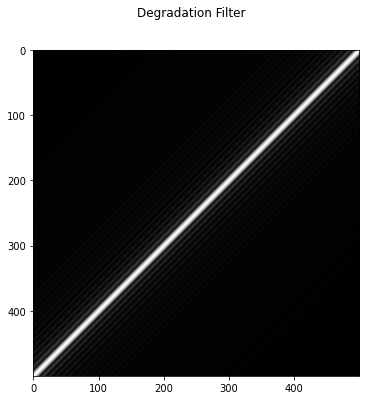

In [67]:
# 绘制滤波器频域图像
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(6, 6))
fig.suptitle('Degradation Filter')
ax.imshow(np.abs(np.array(degrade_filt)), cmap='gray')

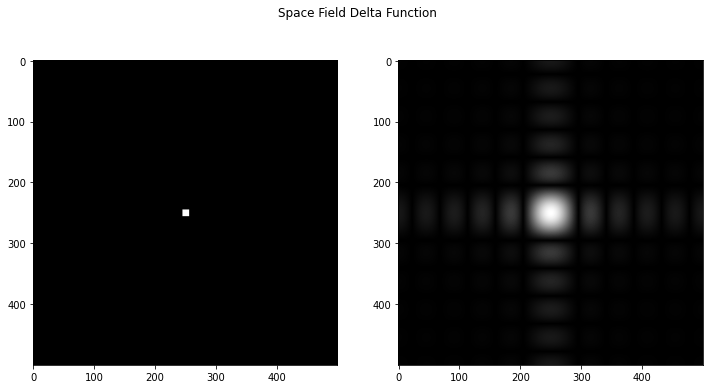

In [66]:
# 构造空域冲激图片
space_delta = [[0.0 for x in range(m)] for y in range(n)]
for i in range(-5, 6):
    for j in range(-5, 6):
        space_delta[n // 2 + i][m // 2 + j] = 1.0

space_delta_fft = np.fft.fftshift(np.fft.fft2(space_delta))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Space Field Delta Function')
ax1.imshow(np.abs(space_delta), cmap='gray')
ax2.imshow(np.abs(space_delta_fft), cmap='gray')

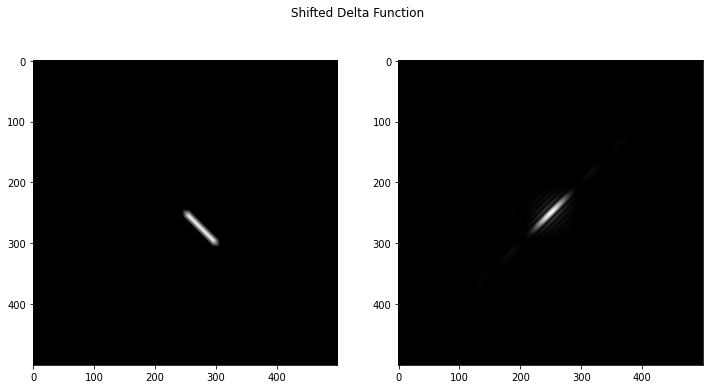

In [65]:
# 应用退化滤波器
space_delta_filt_fft = [[0.0 for x in range(m)] for y in range(n)]
for i in range(n):
    for j in range(m):
        space_delta_filt_fft[i][j] = space_delta_fft[i][j] * degrade_filt[i][j]

space_delta_filt = np.fft.ifft2(np.fft.ifftshift(space_delta_filt_fft))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Shifted Delta Function')
ax1.imshow(np.abs(space_delta_filt), cmap='gray')
ax2.imshow(np.abs(space_delta_filt_fft), cmap='gray')

分别运行上面的代码块，得到的图片结果表明，我们构造的退化滤波器能够使空域的一个方形冲激产生运动模糊的效果。

## 一些测试实例

接下来，我们将运行一些测试实例来展示匀速运动图片退化的效果。

In [82]:
from typing import List

# 构造指定大小的退化滤波器
def get_degrade_filter(n: int, m: int) -> List[List]:
    filt = [[0 for i in range(m)] for j in range(n)]
    for i in range(n):
        for j in range(m):
            filt[i][j] = evaluate_h(i - n // 2, j - m // 2)
    return filt

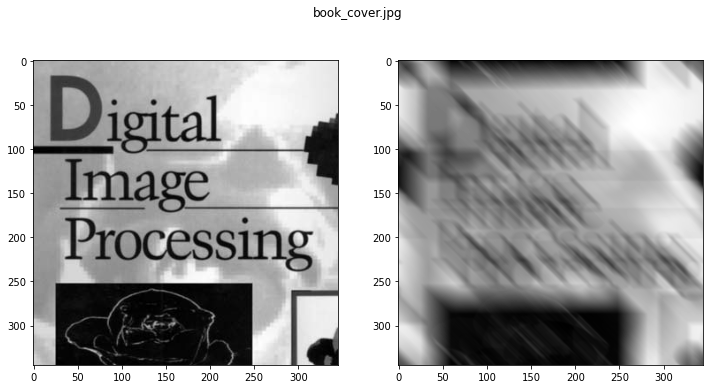

In [85]:
img = plt.imread('book_cover.jpg')
img_fft = np.fft.fftshift(np.fft.fft2(img))

n = len(img)
m = len(img[0])

filt = get_degrade_filter(n, m)
for i in range(n):
    for j in range(m):
        img_fft[i][j] *= filt[i][j]

img_filt = np.abs(np.fft.ifft2(np.fft.ifftshift(img_fft)))
plt.imsave('book_cover_filt.jpg', img_filt, cmap='gray')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('book_cover.jpg')
ax1.imshow(img, cmap='gray')
ax2.imshow(img_filt, cmap='gray')

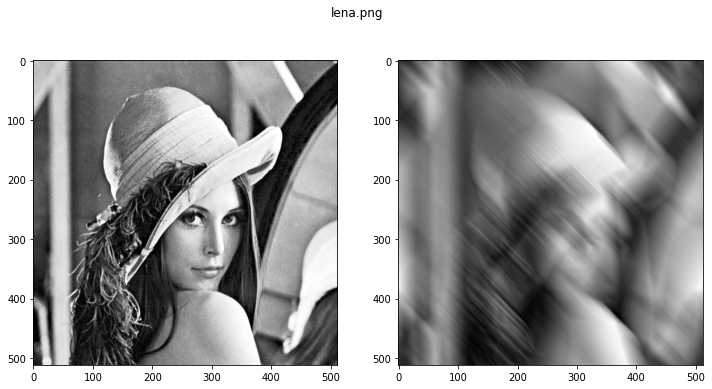

In [84]:
img = plt.imread('lena.png')
img_fft = np.fft.fftshift(np.fft.fft2(img))

n = len(img)
m = len(img[0])

filt = get_degrade_filter(n, m)
for i in range(n):
    for j in range(m):
        img_fft[i][j] *= filt[i][j]

img_filt = np.abs(np.fft.ifft2(np.fft.ifftshift(img_fft)))
plt.imsave('lena_filt.png', img_filt, cmap='gray')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('lena.png')
ax1.imshow(img, cmap='gray')
ax2.imshow(img_filt, cmap='gray')

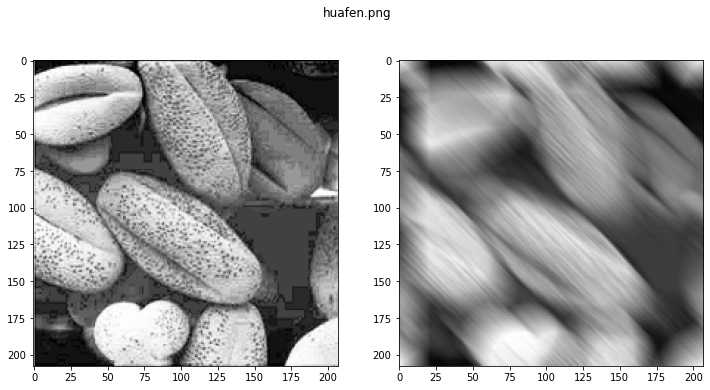

In [83]:
img = plt.imread('huafen.png')
img_fft = np.fft.fftshift(np.fft.fft2(img))

n = len(img)
m = len(img[0])

filt = get_degrade_filter(n, m)
for i in range(n):
    for j in range(m):
        img_fft[i][j] *= filt[i][j]

img_filt = np.abs(np.fft.ifft2(np.fft.ifftshift(img_fft)))
plt.imsave('huafen_filt.png', img_filt, cmap='gray')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('huafen.png')
ax1.imshow(img, cmap='gray')
ax2.imshow(img_filt, cmap='gray')